# ACSE-3 (Numerical Methods) <a class="tocSkip">

## Lecture 10: Finite volume methods (FVM) <a class="tocSkip">
    
### Homework exercises <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Homework" data-toc-modified-id="Homework-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homework</a></span><ul class="toc-item"><li><span><a href="#Homework---Burgers'-equation-in-conservative-vs-advective-form" data-toc-modified-id="Homework---Burgers'-equation-in-conservative-vs-advective-form-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Homework - Burgers' equation in conservative vs advective form</a></span></li><li><span><a href="#Homework---Lax-Friedrichs-for-pure-advection" data-toc-modified-id="Homework---Lax-Friedrichs-for-pure-advection-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Homework - Lax-Friedrichs for pure advection</a></span></li><li><span><a href="#Homework---Lax-Wendroff-for-a-general-conservation-law-[$\star$]" data-toc-modified-id="Homework---Lax-Wendroff-for-a-general-conservation-law-[$\star$]-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Homework - Lax-Wendroff for a general conservation law [$\star$]</a></span></li><li><span><a href="#Homework---Implement-a-finite-volume-based-upwind-method" data-toc-modified-id="Homework---Implement-a-finite-volume-based-upwind-method-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Homework - Implement a finite volume based upwind method</a></span></li><li><span><a href="#Homework---Checking-for-consistency-between-FD-and-FV-implementations-of-LF-in-1D-[$\star$]" data-toc-modified-id="Homework---Checking-for-consistency-between-FD-and-FV-implementations-of-LF-in-1D-[$\star$]-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Homework - Checking for consistency between FD and FV implementations of LF in 1D [$\star$]</a></span></li><li><span><a href="#Homework---Compare-FV-based-UW,-LF,-LFF--[$\star$]" data-toc-modified-id="Homework---Compare-FV-based-UW,-LF,-LFF--[$\star$]-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Homework - Compare FV based UW, LF, LFF  [$\star$]</a></span></li></ul></li></ul></div>

In [2]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

# Homework


## Homework - Burgers' equation in conservative vs advective form

[NB. the first parts of this question is cut and paste from the lecture].

Recall the inviscid form of Burgers' equation

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0,$$

[and recall further that we could only solve this problem in previous lectures if we assumed the viscous form (i.e. added some explicit diffusion), or if we used an upwind rather than a central difference based discretisation].

Notice that this problem can also be written as a conservation law $\,(u_t+f_x=0)\,$ with 

$$ f(u) = \frac{1}{2} u^2. $$

In the continuous world (i.e. before we discretise) these two forms are equivalent.  So does it matter which we base our discretisation on?

The answer is yes, for certain problems, such as those involving shocks. 

Let's demonstrate this with an example.

Consider Burgers' equation in the unit interval with the initial condition that the solution $u$ is equal to one for $x<0.5$ and $u$ is equal to zero for $x>0.5$.

For simplicity let's assume use of forward Euler in time and consider three ways to discretise the spatial derivative term:

**Discretisation 1**

Building on previous lectures the obvious discretisation for the advective form of the problem is the upwind scheme:

$$\frac{u_i^{n+1} - u_i^{n}}{\Delta t} + u_i^{n}\frac{u_i^{n} - u_{i-1}^{n}}{\Delta x}=0.$$


**Discretisation 2**

If we instead perform an upwind discretisation of the conservative form of the problem we have

$$\frac{u_i^{n+1} - u_i^{n}}{\Delta t} + \frac{\frac{1}{2}\left(u_i^{n}\right)^2 - \frac{1}{2}\left(u_{i-1}^{n}\right)^2}{\Delta x}=0.$$


**Discretisation 3**

In this version of the non-conservative based discretisation let's use an average to give is the advective velocity (note for this simple example/flux function, this is actually equivalent to the conservative form)

$$\frac{u_i^{n+1} - u_i^{n}}{\Delta t} + \frac{u_i^{n} + u_{i-1}^{n}}{2} \frac{u_i^{n} - u_{i-1}^{n}}{\Delta x}=0.$$



**Discretisation 4**

We could also test a centred scheme while we're here:

$$\frac{u_i^{n+1} - u_i^{n}}{\Delta t} + u_i^{n}\frac{u_{i+1}^{n} - u_{i-1}^{n}}{2\Delta x}=0.$$



<br>

Implement and compare all of these methods on the problem we considered at the start of the lecture. 

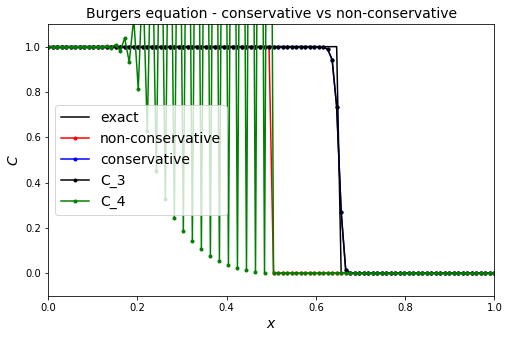

In [5]:
# define spatial mesh
L = 1
N = 100
dx = L / N
x = np.linspace(0, L, N)

# time step 
dt = 0.001
tend = 0.3
t = np.arange(0, tend, dt)

# set up a matrix to store the discrete solution in space-time 
# for our three discretisations
C_noncons = np.zeros((len(x), len(t)))
C_cons = np.zeros((len(x), len(t)))
C_3 = np.zeros((len(x), len(t)))
C_4 = np.zeros((len(x), len(t)))

# define an initial condition
C_noncons[x < 0.5, 0] = 1.0
C_cons[x < 0.5, 0] = 1.0
C_3[x < 0.5, 0] = 1.0
C_4[x < 0.5, 0] = 1.0

# time step
for n in range(len(t)-1):
    # non-conservative scheme (ver 1) - internal discretisation 
    C_noncons[1:, n+1] = C_noncons[1:, n] - (dt / dx) * C_noncons[1:, n] * ( 
                                             C_noncons[1:, n] -   C_noncons[:-1, n] )  
    # and the BC
    C_noncons[0,n+1] = C_noncons[0,0]   
    
    # conservative scheme - internal discretisation 
    C_cons[1:, n+1] = C_cons[1:, n] - (dt / dx) * ( 0.5 * C_cons[1:, n]**2 - 0.5 * C_cons[:-1, n]**2 )  
    # and the BC
    C_cons[0,n+1] = C_cons[0,0]
    
    C_3[1:, n+1] = C_3[1:, n] - (dt / dx / 2.) * (C_3[1:, n] + C_3[:-1, n]) * (C_3[1:, n] - C_3[:-1, n])
    
    C_3[0, n+1] = C_3[0,0]
    
    C_4[1:-1, n+1] = C_4[1:-1,n] - (dt / dx / 2.) * C_4[1:-1,n] * (C_4[2:,n] - C_4[:-2,n])
    
    C_4[0, n+1] = C_4[0,0]
    
# set up figure
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111)
ax1.set_xlim(0, 1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=14)
ax1.set_ylabel('$C$', fontsize=14)
ax1.set_title('Burgers equation - conservative vs non-conservative', fontsize=14)

# for the exact solution just plot the IC translated appropriate amount - see below (Rankine-Hugoniot)
ax1.plot(x,(x < (0.5 + 0.5 * tend)), 'k-', label = 'exact')
ax1.plot(x, C_noncons[:, -1], 'r.-', label='non-conservative')
ax1.plot(x, C_cons[:, -1], 'b.-', label='conservative')
ax1.plot(x, C_3[:, -1], 'k.-', label='C_3')
ax1.plot(x, C_4[:, -1], 'g.-', label='C_4')
ax1.legend(loc='best', fontsize=14);

## Homework - Lax-Friedrichs for pure advection

In the lecture we wrote down the Lax-Friedrichs scheme for pure advection in the form

$$ u_i^{n+1} = \frac{1}{2}(u_{i-1}^n + u_{i+1}^n) - \frac{a \Delta t}{2 \Delta x} (u_{i+1}^n - u_{i-1}^n), $$

although we then went on to solve the advection-diffusion problem that comes from the modified equation analysis.

Write a function to solve L-F in the original form above and verify your implementation against the solver from the lecture.

Hint: in the periodic case think about how you can turn the first term ($\frac{1}{2}(u_{i-1}^n + u_{i+1}^n) $) into a matrix multiplied by the solution vector $c$, and then use this in place of the identity matrix in the amplification factor that appears in the time step update.

## Homework - Lax-Wendroff for a general conservation law [$\star$]

In the lecture we noted that the Lax-Wendroff scheme for a general conservation law takes the form

$$u_i^{n+1} = u_i^n - \frac{\Delta t}{2 \Delta x} \left( f_{i+1}^n - f_{i-1}^n \right) + \frac{(\Delta t)^2}{2(\Delta x)^2} \left( J_{i+1/2}^n (f_{i+1}^n - f_i^n) - J_{i-1/2}^n ( f_i^n - f_{i-1}^n ) \right),$$

where $J_{i\pm 1/2} = J((x_i+x_{i\pm 1})/2)$ is the Jacobian evaluated at an intermediate location between grid points, which could be numerically approximated as $J_{i + 1/2} = (J_{i+1} + J_{i})/2$.  

Implement this form for this solver and compare your result against the solution we obtained with the solver specialised for the pure adection problem.

I.e. assuming a velocity of unity, the flux and Jacobian functions are given by

```Python
def flux_function(q):
    """ function to return the flux 
    """
    return q*np.ones_like(q)

def Jacobian_flux(q):
    return 1.0*np.ones_like(q)
```

Note for this implementation we can't in general assume that $f$ is linear and so we can't write our time-stepping update in terms of a simple matrix multiplication.

But we can write in vectorised for as something like

```Python
q[1:-1, n+1] = q[1:-1, n] - (dt / (2.0 * dx)) * ...
```
and then think about how to deal with the periodic boundaries separately.

## Homework - Implement a finite volume based upwind method

Implement a finite volume based implementation of upwind and compare your result (in the eyeball norm) against the finite difference based implementation from the lecture for pure advection of a Gaussian in a periodic domain.

## Homework - Checking for consistency between FD and FV implementations of LF in 1D [$\star$]

We have claimed that our finite volume code with the Lax-Friedrichs numerical flux should be equivalent with the results from the finite difference implementation of the Lax-Friedrichs method.

Check this in the eye-ball norm for one of our example applications considered in the lecture, e.g. `q_ic = 0.4 * traffic_flow_IC_1(x)`.

## Homework - Compare FV based UW, LF, LFF  [$\star$]

Compare our FV codes with UW, LF and LFF fluxes for the problem with ```Q_ic = 0.4*traffic_flow_IC_1(x)```

What happens when you increase the factor from 0.4 to a value above 0.5?